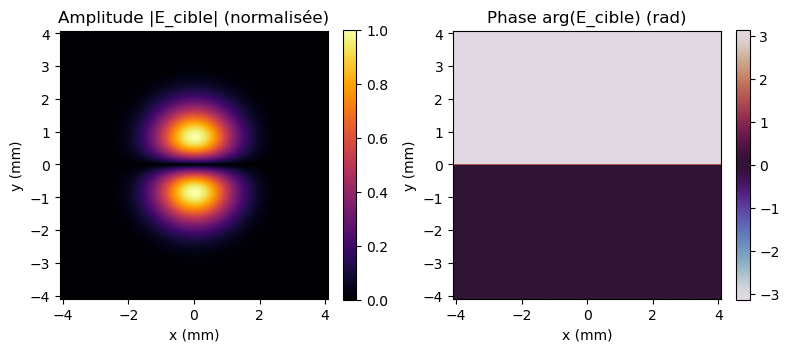

In [13]:
import sys
import os
sys.path.append(os.path.abspath('..'))

import numpy as np
import matplotlib.pyplot as plt
from scipy.special import genlaguerre  # LG modes
from scipy.special import hermite     # Hermite-Gauss modes
from modules.visualisation import look_for_spot_Fspace

# ---------- 0. PARAMÈTRES ----------
λ      = 632e-9          # longueur d'onde (m)
k      = 2*np.pi/λ
N      = 1024             # nombre de pixels (NxN)
dx     = 8e-6            # pitch SLM (m)
w0     = 1.2e-3          # 1/e² incident beam waist (m)
Λ      = 4 * dx          # période du réseau (m)
lg_l   = 1               # ordre azimutal LG (exemple)
lg_p   = 0               # ordre radial LG

# ---------- 1. GRILLE ----------
x = (np.arange(N) - N/2) * dx
X, Y = np.meshgrid(x, x)
R2   = X**2 + Y**2

# ---------- 2. FAISCEAU INCIDENT ----------
Ein = 10*np.exp(-R2 / w0**2)

"""   # ---------- 3. MODE CIBLE (LG) ----------
r    = np.sqrt(R2)
phi  = np.arctan2(Y, X)
wz   = w0  # on néglige la propagation pour l'exemple
rho  = np.sqrt(2) * r / wz
LG   = (rho**abs(lg_l)) * np.exp(-rho**2/2) \
     * genlaguerre(lg_p, abs(lg_l))(rho**2) \
     * np.exp(1j * lg_l * phi)
Edes = LG / LG.max()          # normalisation
Ades, Phides = np.abs(Edes), np.angle(Edes)  
 """

  # ---------- 3. MODE CIBLE (TEM Hermite‑Gauss) ----------
m, n = 0, 1      # ex. TEM01  (mettre 0,0 pour TEM00)

# coordonnées normalisées
xi  = np.sqrt(2) * X / w0
eta = np.sqrt(2) * Y / w0

# polynômes d'Hermite
Hm  = hermite(m)(xi)
Hn  = hermite(n)(eta)
Edes = Hm * Hn * np.exp(-(xi**2 + eta**2)/2)
Edes /= np.max(np.abs(Edes))
Ades  = np.abs(Edes)
Phides = np.angle(Edes)              


# seuil minimum pour ne jamais diviser par ~0
eps = 1e-6 * Ein.max()

# 1) Safe copy d'Ein
Ein_safe = Ein.copy()
Ein_safe[Ein_safe < eps] = eps

# 2) Champ relatif complet (amplitude+phase)
Erel = Edes / Ein_safe

# 3) Extraire amplitude et phase sans jamais faire 0/0
Arel   = np.clip(np.abs(Erel), 0.0, 1.0)    # on borne à 1 si petite sur-modulation
Phirel = np.angle(Erel)   # normalement phirel = phides






# RÉSEAU phi_g - déphase sur les x mais pas les y
Phig = (2*np.pi/Λ) * X                  # rampe linéaire
Phig = np.mod(Phig, 2*np.pi)            # modulo 2π

phirelg = Phig + Phirel          
phirelg = phirelg % (2*np.pi)  




# Échelle en millimètres pour un repère lisible
extent_mm = [x[0]*1e3, x[-1]*1e3, x[0]*1e3, x[-1]*1e3]

fig, ax = plt.subplots(1, 2, figsize=(8, 3.5))

# 1. Amplitude
im0 = ax[0].imshow(Ades, cmap='inferno', extent=extent_mm)
ax[0].set_title('Amplitude |E_cible| (normalisée)')
ax[0].set_xlabel('x (mm)'); ax[0].set_ylabel('y (mm)')
plt.colorbar(im0, ax=ax[0], fraction=0.046)

# 2. Phase
im1 = ax[1].imshow(Phides, cmap='twilight', extent=extent_mm,
                   vmin=-np.pi, vmax=np.pi)
ax[1].set_title('Phase arg(E_cible) (rad)')
ax[1].set_xlabel('x (mm)'); ax[1].set_ylabel('y (mm)')
plt.colorbar(im1, ax=ax[1], fraction=0.046)

plt.tight_layout()
plt.show()







In [17]:

from scipy.optimize import brentq   # résout f(u)=0


def sinc(u):
    return np.where(u==0, 1.0, np.sin(u)/(u))


def sinc_inv(A):
    """
    Inverse numérique de sinc(u)=A pour 0 ≤ A ≤ 1.
    Renvoie u∈[0,π].  A peut être un scalaire ou un tableau.
    """
    A = np.clip(A, 0.0, 1.0)            # sécurise A in [0,1]
    u  = np.empty_like(A, dtype=float)

    # -- cas limites connus analyt.
    mask0 = (A == 0)                    # A=0  -> u = π
    mask1 = (A == 1)                    # A=1  -> u = 0
    mid   = ~(mask0 | mask1)            # 0 < A < 1

    u[mask0] = np.pi
    u[mask1] = 0.0

    # -- racine numérique pour les valeurs intermédiaires
    def _root(a_scalar):
        f = lambda u: sinc(u) - a_scalar
        return brentq(f, 1e-6, np.pi-1e-6, xtol=1e-12)
    if np.any(mid):
        u[mid] = np.vectorize(_root)(A[mid])

    return u


# ---------- données déjà calculées ----------
# Arel   : matrice N×N des amplitudes relatives  (0…1)
# Phirelg: matrice N×N de la phase Φ_relg (en radians)

# ---------- équation H(x,y) ----------
u = sinc_inv(Arel)                 # u = sinc⁻¹(Arel)
H = (1.0 - u/np.pi) * phirelg      # H(x,y) final

SLM = np.exp(1j * H)               # SLM = exp(iH)


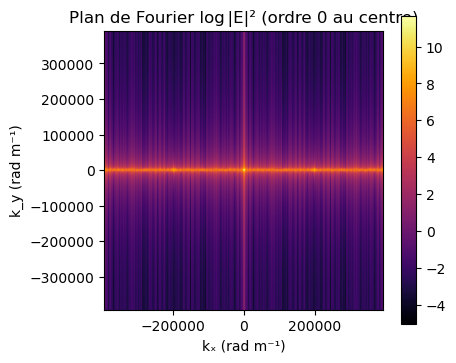

In [18]:
# ---------- 7. CHAMP APRÈS SLM ----------

# ---------- 7. CHAMP APRÈS SLM ----------
E0 = Ein * SLM

# ---------- 8. PLAN DE FOURIER (FFT) ----------
Ef = np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(E0)))

# --- 8b. Axes kx, ky (rad m‑1) avec 0 au centre -------------------------
dk  = 2*np.pi / (N*dx)                     # pas spectral
kx  = np.fft.fftshift(np.fft.fftfreq(N, d=dx)) * 2*np.pi   # vecteur 1‑D
extent_k = [kx[0], kx[-1], kx[0], kx[-1]]  # pour imshow

# Exemple d’affichage (ordre 0 bien au centre (0,0)) :
plt.figure(figsize=(4.5,4))
plt.imshow(np.log10(np.abs(Ef)**2),
           extent=extent_k, origin='lower', cmap='inferno')
plt.xlabel('kₓ (rad m⁻¹)'); plt.ylabel('k_y (rad m⁻¹)')
plt.title('Plan de Fourier log |E|² (ordre 0 au centre)')
plt.colorbar(); plt.show()

# ---------- 9. FILTRE SPATIAL (ordre +1) ----------
# détection automatique du spot (+1 ou –1)
xc, yc = look_for_spot_Fspace(Ef, central_cut=40, side='both')

# diaphragme circulaire adapté (exemple rayon fixe 75 px)
Rmask = 100
Yg, Xg = np.ogrid[:N, :N]
mask = (Yg - yc)**2 + (Xg - xc)**2 < Rmask**2
Ef_masked = Ef * mask

# ----------10. PLAN IMAGE ----------
Eimg  = np.fft.fftshift(np.fft.ifft2(np.fft.ifftshift(Ef_masked)))

# retrait automatique du tilt associé au décalage kx0, ky0
kx0_pix = xc - N//2
kx0     = kx0_pix * dk
Eimg   *= np.exp(-1j * kx0 * X)

Iimg = np.abs(Eimg)**2


RMS erreur amplitude : 0.0409
RMS erreur phase     : 2.0002 rad


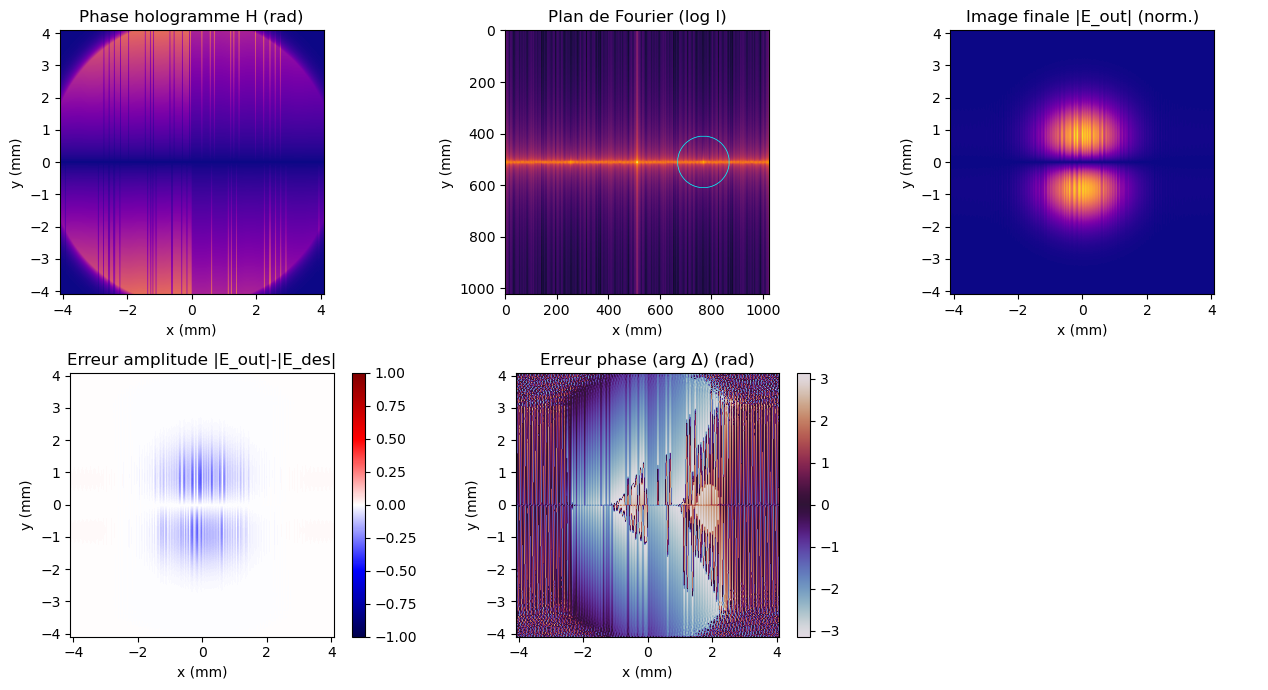

In [21]:

# ---------- erreurs amplitude & phase ----------
# amplitude (normalisées sur leur max)
Amp_des  = np.abs(Edes) / np.abs(Edes).max()
Amp_out  = np.abs(Eimg) / np.abs(Eimg).max()
Amp_err  = Amp_out - Amp_des             # valeurs entre -1 et +1

# phase (différence ramenée à ]‑π,π])
Ph_des   = np.angle(Edes)
Ph_out   = np.angle(Eimg)
# différence de phase « propre »
mask_signal = Amp_des > 0.1   # où on juge le signal significatif
Ph_diff = np.angle(np.exp(1j*(Ph_out - Ph_des)))
#Ph_diff[~mask_signal] = np.nan  # on n’affiche pas les zones silencieuses

# 3) Calcul RMS
rms_amp_err = np.sqrt(np.mean(Amp_err**2))
rms_ph_err  = np.sqrt(np.mean(Ph_diff**2))

# 4) Sortie numérique
print(f"RMS erreur amplitude : {rms_amp_err:.4f}")
print(f"RMS erreur phase     : {rms_ph_err:.4f} rad")



# ---------- tracé ----------
fig, axs = plt.subplots(2, 3, figsize=(13, 7))

# --- ligne 1 : comme avant ---------------------------------
axs[0,0].imshow(H, cmap='plasma', extent=[x[0]*1e3, x[-1]*1e3]*2)
axs[0,0].set_title('Phase hologramme H (rad)')

axs[0,1].imshow(np.log10(np.abs(Ef)**2), cmap='inferno')
axs[0,1].contour(mask, colors='cyan', linewidths=0.5)
axs[0,1].set_title('Plan de Fourier (log I)')
axs[0,1].set_xlabel('fₓ (m⁻¹)'); axs[0,1].set_ylabel('f_y (m⁻¹)')

axs[0,2].imshow(Amp_out, cmap='plasma',
                extent=[x[0]*1e3, x[-1]*1e3]*2)
axs[0,2].set_title('Image finale |E_out| (norm.)')

# --- ligne 2 : nouvelles cartes -----------------------------
im3 = axs[1,0].imshow(Amp_err, cmap='seismic', vmin=-1, vmax=1,
                      extent=[x[0]*1e3, x[-1]*1e3]*2)
axs[1,0].set_title('Erreur amplitude |E_out|-|E_des|')
plt.colorbar(im3, ax=axs[1,0], fraction=0.046)

im4 = axs[1,1].imshow(Ph_diff, cmap='twilight',
                      vmin=-np.pi, vmax=np.pi,
                      extent=[x[0]*1e3, x[-1]*1e3]*2)
axs[1,1].set_title('Erreur phase (arg Δ) (rad)')
plt.colorbar(im4, ax=axs[1,1], fraction=0.046)

# case vide ou autre info (laissons blanc) -------------------
axs[1,2].axis('off')

# --- légendes communes -------------------------------------
for ax in axs.flatten()[:-1]:           # sauf la case blanche
    ax.set_xlabel('x (mm)'); ax.set_ylabel('y (mm)')

plt.tight_layout()
plt.show()

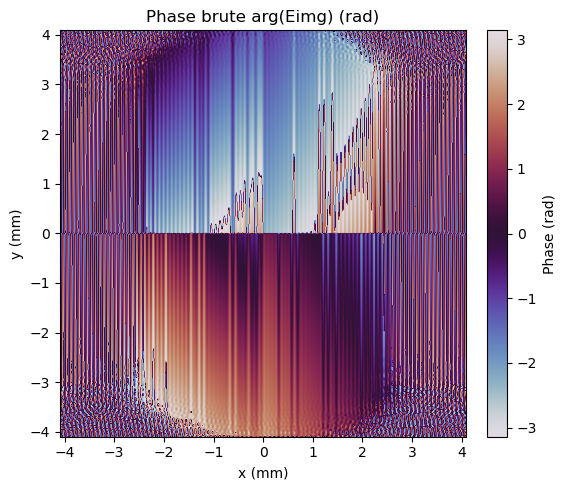

In [20]:
# Préparer l’axe en mm pour l’affichage
extent_mm = [x[0]*1e3, x[-1]*1e3, x[0]*1e3, x[-1]*1e3]

# Phase brute
phase_img = np.angle(Eimg)

plt.figure(figsize=(6,5))
im = plt.imshow(phase_img,
                cmap='twilight', vmin=-np.pi, vmax=np.pi,
                extent=extent_mm, origin='lower')
plt.title("Phase brute arg(Eimg) (rad)")
plt.xlabel("x (mm)"); plt.ylabel("y (mm)")
cbar = plt.colorbar(im, fraction=0.046, pad=0.04)
cbar.set_label("Phase (rad)")
plt.tight_layout()
plt.show()